# Evaluating SwinTransformer on CarbonBench

In this tutorial we will load a SwinTransformer which was pre-trained for atmospheric transport modeling. Then we will run a prediction on a few time steps and evaluate.


We start with importing a few things.

In [16]:
from pathlib import Path
import xarray as xr
import torch
from neural_transport.litmodule import NeuralTransport
from neural_transport.training.train import load_dataset

Then we set a few variables like the Paths to the data and model checkpoint.

In [2]:
CKPT_PATH = "/ptmp/mp002/ellis/carbonbench/weights/swintransformer_S_p1w4_tsaf_specloss.ckpt"
DATA_PATH = "/ptmp/mp002/ellis/carbonbench/data/"
N_GPUS = 1
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_PRED = 16

Let's load the Model!

In [3]:
model = NeuralTransport.load_from_checkpoint(
    CKPT_PATH,
    map_location="cpu",
)

It's a simple PyTorch Lightning Model. We can pretty print:

In [4]:
model

NeuralTransport(
  (model): SwinTransformer(
    (swintransformer): SwinTransformerV2Cr(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(107, 512, kernel_size=(1, 1), stride=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): SwinTransformerV2CrStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): SwinTransformerV2CrBlock(
              (attn): WindowMultiHeadAttention(
                (qkv): Linear(in_features=512, out_features=1536, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=512, out_features=512, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (meta_mlp): Mlp(
                  (fc1): Linear(in_features=2, out_features=384, bias=True)
                  (act): ReLU()
                  (drop1): Dropout(p=0.125, inplace=False)
                  (norm): Identity(

Let's load the data. For this first we need to specify a few settings.

In [5]:
# Setting Data Arguments
grid = "latlon5.625"
vertical_levels = "l10"
freq = "6h"
nlev = 10

data_kwargs = dict(
    data_path=DATA_PATH,
    dataset="carbontracker",
    grid=grid,
    vertical_levels=vertical_levels,
    freq=freq,
    n_timesteps=1,
    batch_size_train=BATCH_SIZE_TRAIN // N_GPUS,
    batch_size_pred=BATCH_SIZE_PRED,
    num_workers=32 * N_GPUS,
    val_rollout_n_timesteps=31,
    target_vars=["co2massmix", "airmass"],
    forcing_vars=[
        "gph_bottom",
        "gph_top",
        "p_bottom",
        "p_top",
        "q",
        "t",
        "u",
        "v",
        "blh",
        "cell_area",
        "co2flux_anthro",
        "co2flux_land",
        "co2flux_ocean",
        "orography",
        "tisr",
    ],
    compute=False,
)


Then we load the Dataset.

In [8]:
dset = load_dataset(Path(DATA_PATH)/"test", data_kwargs)

It is a `CarbonDataset` from the `neural_transport` library.

In [9]:
dset

Let's load a single time step from the Dataset.

In [10]:
t = 0
batch = {k: v.unsqueeze(0).to("cuda") for k, v in dset[t].items()}

The items in the batch will all have shape `b x t x n x c`. With batch size `b = 1`, timesteps `t`, grid cell `n = nlat * nlon` and vertical level `c`.

In [15]:
from collections import defaultdict

# Group keys by their variable prefix (before first underscore or full key if no underscore)
grouped = defaultdict(list)
for k in batch:
    prefix = k.split('_')[0]
    grouped[prefix].append(k)

print("Variables: Dimensions")
for prefix in sorted(grouped):
    keys = grouped[prefix]
    line = ", ".join([f"{k}: {tuple(batch[k].shape)}" for k in sorted(keys)])
    print(line)

Variables: Dimensions
airmass: (1, 1, 2048, 10), airmass_delta_offset: (1, 1, 1, 10), airmass_delta_scale: (1, 1, 1, 10), airmass_next: (1, 1, 2048, 10), airmass_next_offset: (1, 1, 1, 1), airmass_next_scale: (1, 1, 1, 1), airmass_offset: (1, 1, 1, 1), airmass_scale: (1, 1, 1, 1)
blh: (1, 1, 2048, 1), blh_delta_offset: (1, 1, 1, 1), blh_delta_scale: (1, 1, 1, 1), blh_next_offset: (1, 1, 1, 1), blh_next_scale: (1, 1, 1, 1), blh_offset: (1, 1, 1, 1), blh_scale: (1, 1, 1, 1)
cell_area: (1, 1, 2048, 1), cell_area_delta_offset: (1, 1, 1, 1), cell_area_delta_scale: (1, 1, 1, 1), cell_area_next_offset: (1, 1, 1, 1), cell_area_next_scale: (1, 1, 1, 1), cell_area_offset: (1, 1, 1, 1), cell_area_scale: (1, 1, 1, 1)
co2flux_anthro: (1, 1, 2048, 1), co2flux_anthro_delta_offset: (1, 1, 1, 1), co2flux_anthro_delta_scale: (1, 1, 1, 1), co2flux_anthro_next_offset: (1, 1, 1, 1), co2flux_anthro_next_scale: (1, 1, 1, 1), co2flux_anthro_offset: (1, 1, 1, 1), co2flux_anthro_scale: (1, 1, 1, 1), co2flux_lan

Let's move the model to GPU and predict a single time step!

In [18]:
model.eval()
model.to("cuda")
with torch.no_grad():
    preds = model(batch)

We have predicted CO2 for the next time step!

In [19]:
preds

{'co2massmix': tensor([[[[613.9532, 613.9124, 613.9329,  ..., 614.4479, 611.0809, 599.9411],
           [613.9672, 613.8958, 613.9367,  ..., 614.4557, 611.0787, 599.9413],
           [613.9232, 613.9081, 613.9516,  ..., 614.4857, 611.0723, 599.8934],
           ...,
           [633.6194, 633.4299, 633.8425,  ..., 620.6019, 612.7441, 598.9229],
           [633.0333, 633.2606, 633.7209,  ..., 620.7202, 612.8210, 599.0056],
           [633.2071, 633.3950, 633.8226,  ..., 620.7690, 612.8641, 599.0496]]]],
        device='cuda:0')}

Let's plot against the targets!

In [28]:
%matplotlib inline

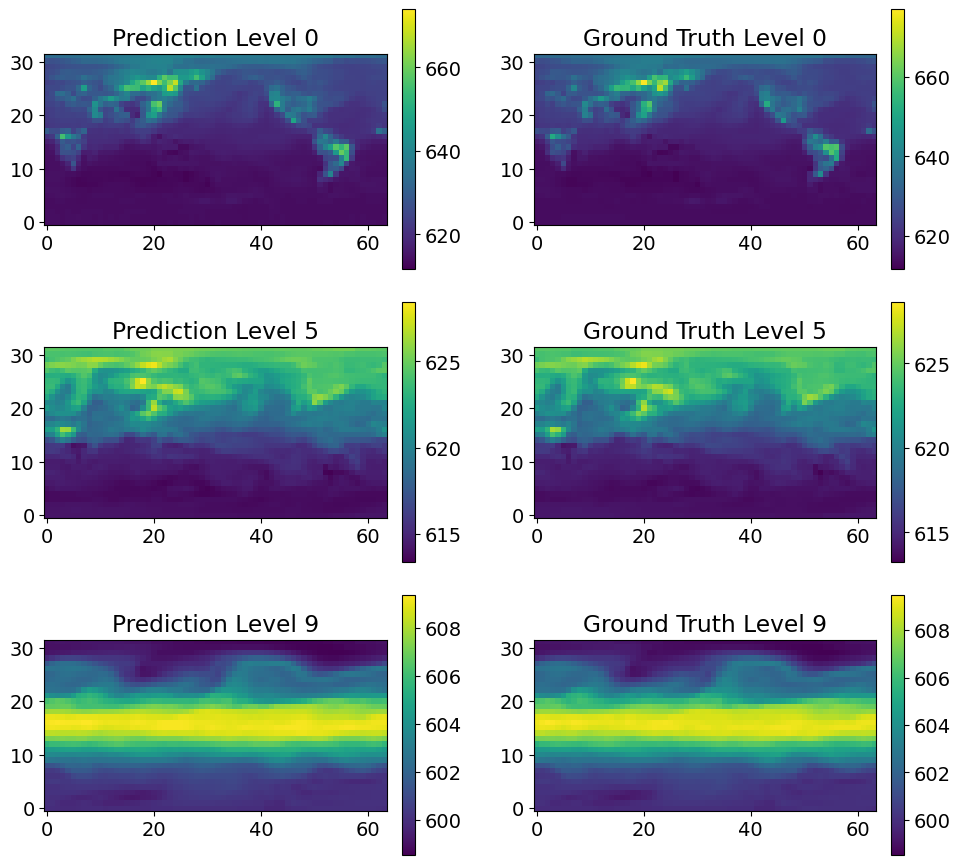

In [29]:
import matplotlib.pyplot as plt

# Get tensors and move to cpu
pred = preds["co2massmix"].squeeze().cpu().numpy()  # shape: nloc x nlev
truth = batch["co2massmix_next"].squeeze().cpu().numpy()  # shape: nloc x nlev

# Get grid shape from dset
nlat = 32
nlon = 64

# Select 3 levels to plot (e.g., bottom, middle, top)
levels = [0, nlev // 2, nlev - 1]
level_names = [f"Level {i}" for i in levels]

fig, axes = plt.subplots(len(levels), 2, figsize=(10, 3 * len(levels)))
for i, lev in enumerate(levels):
    pred_map = pred[:, lev].reshape(nlat, nlon)
    truth_map = truth[:, lev].reshape(nlat, nlon)
    # Prediction
    ax = axes[i, 0]
    im = ax.imshow(pred_map, origin="lower")
    ax.set_title(f"Prediction {level_names[i]}")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # Ground Truth
    ax = axes[i, 1]
    im = ax.imshow(truth_map, origin="lower")
    ax.set_title(f"Ground Truth {level_names[i]}")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()